In [200]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
import lightgbm as lgb
from itertools import combinations

# from catboost import Pool, CatBoostRegressor
# from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
weather = pd.read_csv('data/weather_v2.csv')
target = pd.read_csv('data/EDA_target.csv')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cols = ['temp', 'ws', 'wd', 'humid', 'landP', 'seaP', 'sfctemp']

# 5. 모델 학습 및 검증
- lgbm을 이용하여 2가지 모델 작성

 
- 1) 과거 정보를 이용해 supply, 기상정보를 예측하는 모델 (시계열 모델)

- 2) supply, 기상정보를 이용하여 smp를 예측하는 모델 (상관관계 모델)

- 1)의 모델을 이용해 supply, 기상정보를 예측한 후 2)의 모델로 smp를 예측

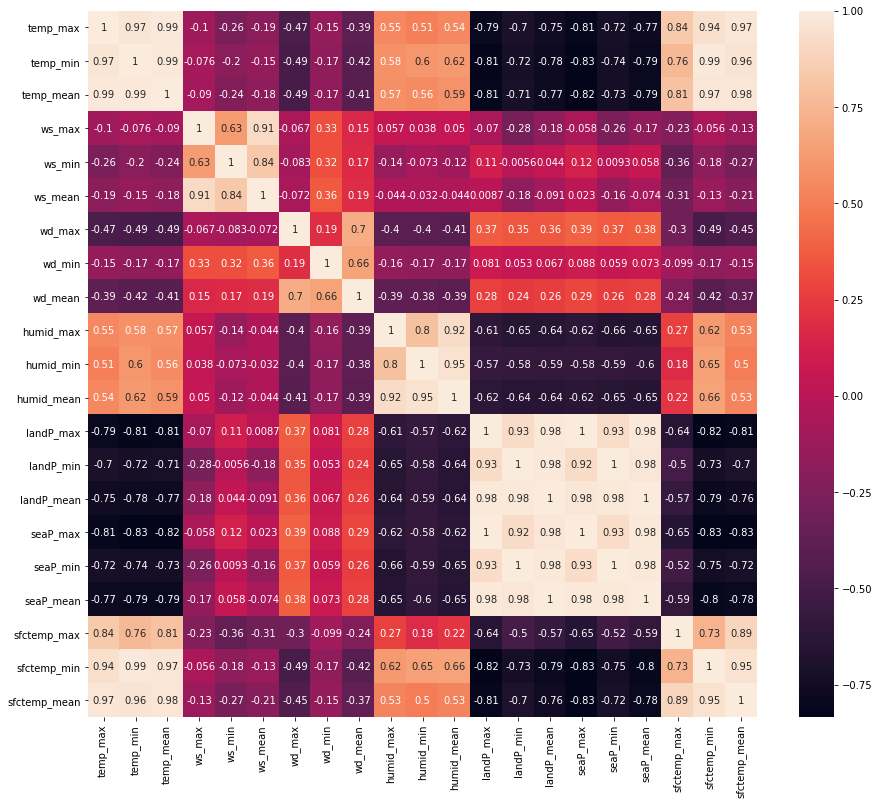

In [4]:
plt.rcParams['figure.figsize'] = [15, 13]
sns.heatmap(target[target.columns[9:-3]].corr(), annot=True)

In [5]:
past = 29 # 최근 30일 정보를 이용하여 n일 후를 예측

In [6]:
def trans(dataset, start_index, end_index, past, future, x_columns, y_columns):
    dataset.index = range(dataset.shape[0])
    data = []
    labels = []
    
    start_index = start_index + past
    
    if end_index is None:
        end_index = dataset.shape[0]
    
    for i in range(start_index, end_index-future):
        indices = np.array(dataset.loc[i-past:i, x_columns])
        data.append(indices)
        
        labels.append(np.array(dataset.loc[i+future, y_columns]))
        
    data = np.array(data)
    data = data.reshape(data.shape[0], -1)
    labels = np.array(labels)
    labels = labels.reshape(-1)
    
    return data, labels

In [10]:
def create_model(x_train, y_train, x_val, y_val):
    params = {
        'metric': 'mae',
        'seed':7777
        }
    
    d_train = lgb.Dataset(x_train, y_train)
    d_val = lgb.Dataset(x_val, y_val)

    model = lgb.train(params, d_train, 1200, \
                      d_val, verbose_eval=False, \
                      early_stopping_rounds=800)

    return model

In [11]:
x_columns = ['landP_mean', 'seaP_mean', 'sfctemp_mean', \
             'stand_temp_max', 'stand_temp_min', 'stand_temp_mean', \
             'year', 'month', 'day', 'dayofweek']

## Supply

In [12]:
y_columns = ['supply']
supply_models = {}
scores = list()

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30 # 마지막 30일을 validation set으로 사용
    x_train, y_train = trans(target, 0, train_split, past, future, x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, x_columns, y_columns)

    supply_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = supply_models[future].predict(x_val)
    
    score = dict(supply_models[future].best_score)['valid_0']['l1']
    scores.append(score)

In [13]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 3.744119492070999
min 2.6640742580778976
max 4.409073724835693


# Temp

In [14]:
temp_x_columns = ['temp_max', 'temp_min', 'temp_mean', \
                  'sfctemp_max', 'sfctemp_min', 'sfctemp_mean', \
                  'year', 'month', 'day']

## Max

In [15]:
y_columns = ['temp_max']
temp_max_models = {}
scores = list()

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, temp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, temp_x_columns, y_columns)
    
    temp_max_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = temp_max_models[future].predict(x_val)

    score = dict(temp_max_models[future].best_score)['valid_0']['l1']
    scores.append(score)

In [16]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 1.9213066112713746
min 1.5449128636557268
max 2.1566764613566076


## temp min

In [17]:
y_columns = ['temp_min']
temp_min_models = {}
scores = list()

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, temp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, temp_x_columns, y_columns)
    
    temp_min_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = temp_min_models[future].predict(x_val)
    
    score = dict(temp_max_models[future].best_score)['valid_0']['l1']
    scores.append(score)

In [18]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 1.9213066112713746
min 1.5449128636557268
max 2.1566764613566076


# temp mean

In [19]:
y_columns = ['temp_mean']
temp_mean_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, temp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, temp_x_columns, y_columns)
    
    temp_mean_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = temp_mean_models[future].predict(x_val)

    score = dict(temp_max_models[future].best_score)['valid_0']['l1']
    scores.append(score)

In [20]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 1.9213066112713746
min 1.5449128636557268
max 2.1566764613566076


# sfctemp

In [21]:
sfctemp_x_columns = ['temp_max', 'temp_min', 'temp_mean', \
                  'sfctemp_max', 'sfctemp_min', 'sfctemp_mean', \
                  'year', 'month', 'day']

## Max

In [22]:
y_columns = ['sfctemp_max']
sfctemp_max_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, sfctemp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, sfctemp_x_columns, y_columns)
    
    sfctemp_max_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = sfctemp_max_models[future].predict(x_val)

    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [23]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.694878957760332
min 4.244046672480272
max 5.304968869537879


## Min

In [24]:
y_columns = ['sfctemp_min']
sfctemp_min_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, sfctemp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, sfctemp_x_columns, y_columns)
    
    sfctemp_min_models[future] = create_model(x_train, y_train, x_val, y_val)    
    pred = sfctemp_min_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [25]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 2.985184255703769
min 2.714813117838168
max 3.163600657457509


## Mean

In [26]:
y_columns = ['sfctemp_mean']
sfctemp_mean_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, sfctemp_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, sfctemp_x_columns, y_columns)
    
    sfctemp_mean_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = sfctemp_mean_models[future].predict(x_val)

    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [27]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 2.0652914695422706
min 1.810967525062576
max 2.543144880947543


# landP

In [28]:
press_x_columns = ['landP_max', 'landP_min', 'landP_mean', \
                  'seaP_max', 'seaP_min', 'seaP_mean', \
                  'year', 'month', 'day']

## Max

In [29]:
y_columns = ['landP_max']
landP_max_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    landP_max_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = landP_max_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [30]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.005260844028348
min 3.592462921738547
max 4.399431056012179


## Min

In [31]:
y_columns = ['landP_min']
landP_min_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    landP_min_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = landP_min_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [32]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.800689599448553
min 4.498078266015174
max 5.128929576971454


## Mean

In [33]:
y_columns = ['landP_mean']
landP_mean_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    landP_mean_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = landP_mean_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [34]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.499503861014455
min 4.178725402372224
max 4.8714907718169


# seaP

## Max

In [35]:
y_columns = ['landP_max']
seaP_max_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    seaP_max_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = seaP_max_models[future].predict(x_val)

    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [36]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.005260844028348
min 3.592462921738547
max 4.399431056012179


## Min

In [37]:
y_columns = ['landP_min']
seaP_min_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    seaP_min_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = seaP_min_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [38]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.800689599448553
min 4.498078266015174
max 5.128929576971454


## Mean

In [39]:
y_columns = ['landP_mean']
seaP_mean_models = {}
scores = []

# 7일~34일 후를 예측하는 각각의 모델 구축
for future in range(7, 35):
    train_split = target.shape[0]-past-future-30
    x_train, y_train = trans(target, 0, train_split, past, future, press_x_columns, y_columns)
    x_val, y_val = trans(target, train_split, None, past, future, press_x_columns, y_columns)
    
    seaP_mean_models[future] = create_model(x_train, y_train, x_val, y_val)
    pred = seaP_mean_models[future].predict(x_val)
    
    score = mean_absolute_error(y_val, pred)
    scores.append(score)

In [40]:
print("mean", sum(scores) / len(scores))
print("min", min(scores))
print("max", max(scores))

mean 4.499503861014455
min 4.178725402372224
max 4.8714907718169


# Predict future

In [41]:
display(target)
print(target.shape)

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,...,landP_mean,seaP_max,seaP_min,seaP_mean,sfctemp_max,sfctemp_min,sfctemp_mean,stand_temp_max,stand_temp_min,stand_temp_mean
0,2018-02-01,150.65,116.84,132.71,87.47,2018,2,1,3,5.95,...,1021.827083,1028.65,1025.65,1026.722917,13.45,1.45,4.293750,-1.785005,-1.661420,-1.433158
1,2018-02-02,163.86,116.84,134.19,86.64,2018,2,2,4,5.25,...,1022.212500,1028.55,1026.15,1027.408333,13.70,0.85,4.072917,-1.884273,-1.761867,-1.550427
2,2018-02-03,164.07,116.85,131.39,88.28,2018,2,3,5,4.00,...,1022.839583,1028.60,1026.05,1027.387500,4.25,0.55,2.060417,-2.061538,-2.061732,-1.957419
3,2018-02-04,171.00,115.76,131.89,86.14,2018,2,4,6,0.30,...,1023.377083,1028.35,1026.65,1027.793750,3.80,0.15,1.150000,-2.586243,-2.407255,-2.171263
4,2018-02-05,170.34,123.89,137.96,90.63,2018,2,5,0,2.05,...,1022.018750,1028.40,1024.15,1026.366667,4.85,0.25,1.502083,-2.338072,-2.264097,-2.122975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2020-05-14,193.28,66.78,100.46,62.70,2020,5,14,3,22.35,...,1012.525000,1019.30,1013.35,1016.764583,31.90,11.90,20.660417,0.540714,0.417315,0.174117
834,2020-05-15,198.23,61.81,102.38,64.91,2020,5,15,4,21.50,...,1004.537500,1013.20,1006.75,1008.741667,24.85,18.60,20.304167,0.420173,0.503622,0.650091
835,2020-05-16,220.91,88.50,121.19,61.75,2020,5,16,5,19.05,...,1002.822917,1008.80,1005.50,1007.195833,24.40,17.60,20.197917,0.072734,0.230856,0.284488
836,2020-05-17,207.75,65.78,116.82,61.55,2020,5,17,6,20.35,...,1002.068750,1007.50,1004.90,1006.322917,31.35,15.90,21.227083,0.257089,0.140130,0.084441


(838, 33)


# Submit

## Supply

In [42]:
x_test = np.array(target.loc[808:, x_columns])
x_test = x_test.reshape(1,-1)

In [43]:
supply_result=[]
for future in range(7, 35):
    supply_result.append(supply_models[future].predict(x_test))
supply_result = np.array(supply_result).reshape(-1)

## Temp

In [44]:
x_test = np.array(target.loc[808:, temp_x_columns])
x_test = x_test.reshape(1,-1)

In [45]:
temp_max_result=[]
for future in range(7, 35):
    temp_max_result.append(temp_max_models[future].predict(x_test))
temp_max_result = np.array(temp_max_result).reshape(-1)

In [46]:
temp_min_result=[]
for future in range(7, 35):
    temp_min_result.append(temp_min_models[future].predict(x_test))
temp_min_result = np.array(temp_min_result).reshape(-1)

In [47]:
temp_mean_result=[]
for future in range(7, 35):
    temp_mean_result.append(temp_mean_models[future].predict(x_test))
temp_mean_result = np.array(temp_mean_result).reshape(-1)

## Sfctemp

In [48]:
x_test = np.array(target.loc[808:, sfctemp_x_columns])
x_test = x_test.reshape(1,-1)

In [49]:
sfctemp_max_result=[]
for future in range(7, 35):
    sfctemp_max_result.append(sfctemp_max_models[future].predict(x_test))
sfctemp_max_result = np.array(sfctemp_max_result).reshape(-1)

In [50]:
sfctemp_min_result=[]
for future in range(7, 35):
    sfctemp_min_result.append(sfctemp_min_models[future].predict(x_test))
sfctemp_min_result = np.array(sfctemp_min_result).reshape(-1)

In [51]:
sfctemp_mean_result=[]
for future in range(7, 35):
    sfctemp_mean_result.append(sfctemp_mean_models[future].predict(x_test))
sfctemp_mean_result = np.array(sfctemp_mean_result).reshape(-1)

## LandP

In [52]:
x_test = np.array(target.loc[808:, press_x_columns])
x_test = x_test.reshape(1,-1)

In [53]:
landP_max_result=[]
for future in range(7, 35):
    landP_max_result.append(landP_max_models[future].predict(x_test))
landP_max_result = np.array(landP_max_result).reshape(-1)

In [54]:
landP_min_result=[]
for future in range(7, 35):
    landP_min_result.append(landP_min_models[future].predict(x_test))
landP_min_result = np.array(landP_min_result).reshape(-1)

In [55]:
landP_mean_result=[]
for future in range(7, 35):
    landP_mean_result.append(landP_mean_models[future].predict(x_test))
landP_mean_result = np.array(landP_mean_result).reshape(-1)

## SeaP

In [56]:
seaP_max_result=[]
for future in range(7, 35):
    seaP_max_result.append(seaP_max_models[future].predict(x_test))
seaP_max_result = np.array(seaP_max_result).reshape(-1)

In [57]:
seaP_min_result=[]
for future in range(7, 35):
    seaP_min_result.append(seaP_min_models[future].predict(x_test))
seaP_min_result = np.array(seaP_min_result).reshape(-1)

In [58]:
seaP_mean_result=[]
for future in range(7, 35):
    seaP_mean_result.append(seaP_mean_models[future].predict(x_test))
seaP_mean_result = np.array(seaP_mean_result).reshape(-1)

# Create Data

In [130]:
submission = pd.read_csv('data/sample_submission.csv')
submission_top_half = submission.loc[:27,:]
submission = submission.loc[28:,:]
test = submission.copy()
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test['dayofweek'] = test['date'].dt.dayofweek
test['supply'] = np.array(supply_result).reshape(-1)
test['temp_max'] = np.array(temp_max_result).reshape(-1)
test['temp_min'] = np.array(temp_min_result).reshape(-1)
test['temp_mean'] = np.array(temp_mean_result).reshape(-1)

test['sfctemp_max'] = np.array(sfctemp_max_result).reshape(-1)
test['sfctemp_min'] = np.array(sfctemp_min_result).reshape(-1)
test['sfctemp_mean'] = np.array(sfctemp_mean_result).reshape(-1)

test['landP_max'] = np.array(landP_max_result).reshape(-1)
test['landP_min'] = np.array(landP_min_result).reshape(-1)
test['landP_mean'] = np.array(landP_mean_result).reshape(-1)

test['seaP_max'] = np.array(seaP_max_result).reshape(-1)
test['seaP_min'] = np.array(seaP_min_result).reshape(-1)
test['seaP_mean'] = np.array(seaP_mean_result).reshape(-1)

scaler_max = StandardScaler().fit(target[['temp_max', 'supply']])
scaler_min = StandardScaler().fit(target[['temp_min', 'supply']])
scaler_mean = StandardScaler().fit(target[['temp_mean', 'supply']])

test['stand_temp_max'] = scaler_max.transform(test[['temp_max', 'supply']])[:, 0]
test['stand_temp_min'] = scaler_min.transform(test[['temp_min', 'supply']])[:, 0]
test['stand_temp_mean'] = scaler_mean.transform(test[['temp_mean', 'supply']])[:, 0]

test.head()

,date,smp_max,smp_min,smp_mean,supply,year,month,day,dayofweek,temp_max,...,sfctemp_mean,landP_max,landP_min,landP_mean,seaP_max,seaP_min,seaP_mean,stand_temp_max,stand_temp_min,stand_temp_mean
28,2020-05-25,0,0,0,66.916638,2020,5,25,0,21.286655,...,22.654872,1012.218116,1003.157906,1007.929107,1012.218116,1003.157906,1007.929107,0.389919,0.472915,0.472647
29,2020-05-26,0,0,0,66.764001,2020,5,26,1,22.577984,...,23.002663,1010.211485,1003.075825,1006.215518,1010.211485,1003.075825,1006.215518,0.573045,0.683088,0.264158
30,2020-05-27,0,0,0,65.606743,2020,5,27,2,19.820661,...,22.912925,1007.784970,1003.501854,1006.741007,1007.784970,1003.501854,1006.741007,0.182023,0.559361,0.565054
31,2020-05-28,0,0,0,67.146668,2020,5,28,3,21.298735,...,21.055398,1007.914318,1002.751716,1007.923070,1007.914318,1002.751716,1007.923070,0.391632,0.606041,0.571444
32,2020-05-29,0,0,0,68.404725,2020,5,29,4,20.133870,...,21.433915,1009.125553,1001.329454,1007.078165,1009.125553,1001.329454,1007.078165,0.226440,0.342199,0.384044


In [260]:
origin_x_columns = x_columns.copy()

new_x_columns = ['landP_min', 'landP_mean', \
                 'seaP_max', 'seaP_min', 'seaP_mean', \
                 'sfctemp_max', 'sfctemp_mean', \
                 'stand_temp_max', 'stand_temp_min', 'stand_temp_mean',\
                 'year', 'month', 'day', 'dayofweek', \
                ]

In [292]:
def create_model(x_data, y_data, k=5):
    models = []
    scores_l1 = []
    scores_l2 = []
    params = {
        'metric': ['mae', 'mse'],
        'seed':777,
        'learning_rate' : 0.002
    }
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
   
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, d_train, 50000, d_val, \
                          verbose_eval=1000, \
                          early_stopping_rounds=50000)
        
        pred = model.predict(x_val)
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(pred, '.-', label='y_pred')
        plt.legend()
        plt.show()
        
        models.append(model)
        
        score_l1 = dict(model.best_score)['valid_0']['l1']
        score_l2 = dict(model.best_score)['valid_0']['l2']
        
        scores_l1.append(score_l1)
        scores_l2.append(score_l2)
        
    return models, (sum(scores_l1) / len(scores_l1), sum(scores_l2)/ len(scores_l2))

In [293]:
x_columns = new_x_columns

train column :  smp_min
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 12.1216	valid_0's l2: 316.174
[2000]	valid_0's l1: 11.3074	valid_0's l2: 324.653
[3000]	valid_0's l1: 11.4172	valid_0's l2: 329.641
[4000]	valid_0's l1: 11.5144	valid_0's l2: 330.248
[5000]	valid_0's l1: 11.6634	valid_0's l2: 331.053
[6000]	valid_0's l1: 11.7627	valid_0's l2: 331.692
[7000]	valid_0's l1: 11.8744	valid_0's l2: 333.382
[8000]	valid_0's l1: 11.9461	valid_0's l2: 334.071
[9000]	valid_0's l1: 11.9917	valid_0's l2: 333.303
[10000]	valid_0's l1: 12.0352	valid_0's l2: 333.84
[11000]	valid_0's l1: 12.0781	valid_0's l2: 334.278
[12000]	valid_0's l1: 12.1231	valid_0's l2: 335.402
[13000]	valid_0's l1: 12.1525	valid_0's l2: 335.598
[14000]	valid_0's l1: 12.1765	valid_0's l2: 335.793
[15000]	valid_0's l1: 12.1898	valid_0's l2: 336.193
[16000]	valid_0's l1: 12.2111	valid_0's l2: 336.87
[17000]	valid_0's l1: 12.2222	valid_0's l2: 337.25
[18000]	valid_0's l1: 12.2354	valid_0's 

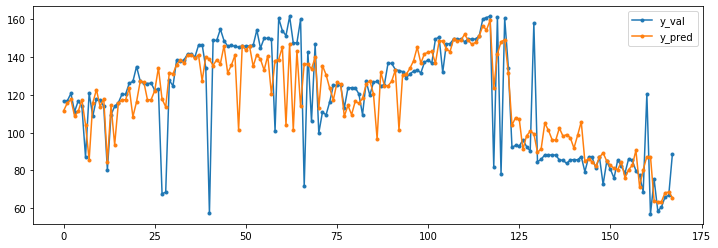

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 11.3341	valid_0's l2: 288.695
[2000]	valid_0's l1: 10.3513	valid_0's l2: 277.197
[3000]	valid_0's l1: 10.4813	valid_0's l2: 277.509
[4000]	valid_0's l1: 10.662	valid_0's l2: 280.393
[5000]	valid_0's l1: 10.7838	valid_0's l2: 281.046
[6000]	valid_0's l1: 10.9104	valid_0's l2: 282.444
[7000]	valid_0's l1: 11.0324	valid_0's l2: 285.484
[8000]	valid_0's l1: 11.0689	valid_0's l2: 286.971
[9000]	valid_0's l1: 11.1171	valid_0's l2: 288.653
[10000]	valid_0's l1: 11.1593	valid_0's l2: 289.828
[11000]	valid_0's l1: 11.2063	valid_0's l2: 291.344
[12000]	valid_0's l1: 11.2255	valid_0's l2: 291.853
[13000]	valid_0's l1: 11.2544	valid_0's l2: 292.408
[14000]	valid_0's l1: 11.2773	valid_0's l2: 293.002
[15000]	valid_0's l1: 11.3021	valid_0's l2: 293.961
[16000]	valid_0's l1: 11.3395	valid_0's l2: 295.367
[17000]	valid_0's l1: 11.3668	valid_0's l2: 296.586
[18000]	valid_0's l1: 11.3923	valid_0's l2: 297.674
[19000]	va

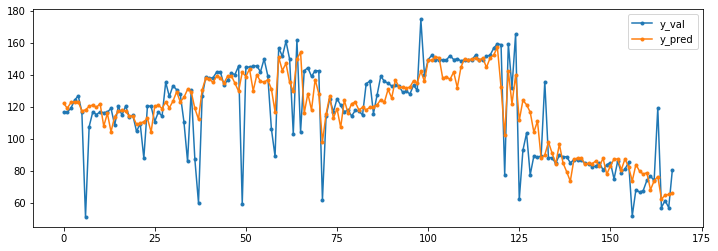

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 11.2788	valid_0's l2: 282.375
[2000]	valid_0's l1: 10.3787	valid_0's l2: 285.997
[3000]	valid_0's l1: 10.6661	valid_0's l2: 294.212
[4000]	valid_0's l1: 10.9483	valid_0's l2: 303.479
[5000]	valid_0's l1: 11.0788	valid_0's l2: 308.842
[6000]	valid_0's l1: 11.1955	valid_0's l2: 314.521
[7000]	valid_0's l1: 11.3246	valid_0's l2: 318.345
[8000]	valid_0's l1: 11.4389	valid_0's l2: 321.59
[9000]	valid_0's l1: 11.54	valid_0's l2: 325.273
[10000]	valid_0's l1: 11.6491	valid_0's l2: 328.644
[11000]	valid_0's l1: 11.7307	valid_0's l2: 330.785
[12000]	valid_0's l1: 11.7717	valid_0's l2: 332.287
[13000]	valid_0's l1: 11.8286	valid_0's l2: 333.99
[14000]	valid_0's l1: 11.8659	valid_0's l2: 335.236
[15000]	valid_0's l1: 11.8925	valid_0's l2: 336.213
[16000]	valid_0's l1: 11.915	valid_0's l2: 336.98
[17000]	valid_0's l1: 11.9429	valid_0's l2: 337.945
[18000]	valid_0's l1: 11.963	valid_0's l2: 338.647
[19000]	valid_0'

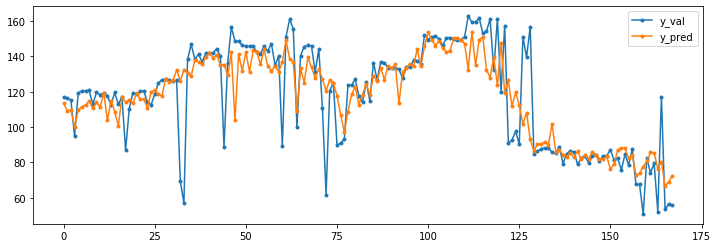

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 9.55396	valid_0's l2: 192.298
[2000]	valid_0's l1: 8.26021	valid_0's l2: 160.782
[3000]	valid_0's l1: 8.22583	valid_0's l2: 157.477
[4000]	valid_0's l1: 8.327	valid_0's l2: 155.929
[5000]	valid_0's l1: 8.41114	valid_0's l2: 155.687
[6000]	valid_0's l1: 8.47698	valid_0's l2: 155.763
[7000]	valid_0's l1: 8.5375	valid_0's l2: 155.973
[8000]	valid_0's l1: 8.57565	valid_0's l2: 156.44
[9000]	valid_0's l1: 8.62835	valid_0's l2: 156.921
[10000]	valid_0's l1: 8.65507	valid_0's l2: 157.085
[11000]	valid_0's l1: 8.69537	valid_0's l2: 156.929
[12000]	valid_0's l1: 8.72516	valid_0's l2: 157.256
[13000]	valid_0's l1: 8.75151	valid_0's l2: 157.56
[14000]	valid_0's l1: 8.77487	valid_0's l2: 157.688
[15000]	valid_0's l1: 8.79098	valid_0's l2: 157.539
[16000]	valid_0's l1: 8.80465	valid_0's l2: 157.446
[17000]	valid_0's l1: 8.82558	valid_0's l2: 157.709
[18000]	valid_0's l1: 8.83941	valid_0's l2: 157.846
[19000]	valid_

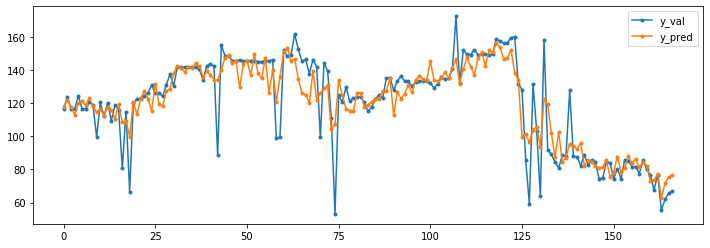

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 9.3952	valid_0's l2: 180.112
[2000]	valid_0's l1: 8.55015	valid_0's l2: 170.854
[3000]	valid_0's l1: 8.63246	valid_0's l2: 171.07
[4000]	valid_0's l1: 8.72618	valid_0's l2: 170.327
[5000]	valid_0's l1: 8.78936	valid_0's l2: 171.791
[6000]	valid_0's l1: 8.87935	valid_0's l2: 172.131
[7000]	valid_0's l1: 8.93804	valid_0's l2: 172.623
[8000]	valid_0's l1: 8.93919	valid_0's l2: 172.891
[9000]	valid_0's l1: 8.99923	valid_0's l2: 174.059
[10000]	valid_0's l1: 9.0197	valid_0's l2: 174.377
[11000]	valid_0's l1: 9.06511	valid_0's l2: 175.4
[12000]	valid_0's l1: 9.09247	valid_0's l2: 175.661
[13000]	valid_0's l1: 9.1097	valid_0's l2: 176.035
[14000]	valid_0's l1: 9.13242	valid_0's l2: 176.255
[15000]	valid_0's l1: 9.16076	valid_0's l2: 176.674
[16000]	valid_0's l1: 9.19209	valid_0's l2: 177.243
[17000]	valid_0's l1: 9.22059	valid_0's l2: 177.917
[18000]	valid_0's l1: 9.22577	valid_0's l2: 177.871
[19000]	valid_0

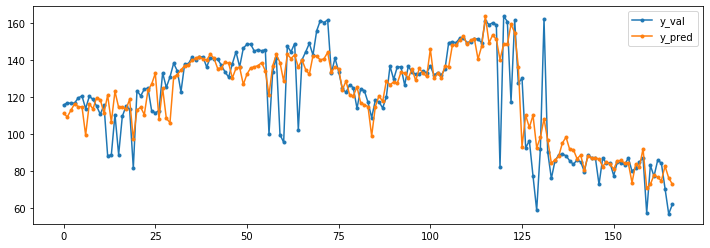

(9.749190995229169, 242.94223674183007)
train column :  smp_max
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 15.6459	valid_0's l2: 423.979
[2000]	valid_0's l1: 15.6648	valid_0's l2: 433.829
[3000]	valid_0's l1: 15.8479	valid_0's l2: 448.507
[4000]	valid_0's l1: 16.0148	valid_0's l2: 458.988
[5000]	valid_0's l1: 16.1304	valid_0's l2: 467.667
[6000]	valid_0's l1: 16.1635	valid_0's l2: 474.62
[7000]	valid_0's l1: 16.2436	valid_0's l2: 482.689
[8000]	valid_0's l1: 16.3625	valid_0's l2: 491.546
[9000]	valid_0's l1: 16.5194	valid_0's l2: 501.466
[10000]	valid_0's l1: 16.651	valid_0's l2: 510.931
[11000]	valid_0's l1: 16.7759	valid_0's l2: 520.819
[12000]	valid_0's l1: 16.8399	valid_0's l2: 528.098
[13000]	valid_0's l1: 16.9166	valid_0's l2: 536.841
[14000]	valid_0's l1: 16.9705	valid_0's l2: 544.32
[15000]	valid_0's l1: 17.0373	valid_0's l2: 551.114
[16000]	valid_0's l1: 17.0891	valid_0's l2: 557.87
[17000]	valid_0's l1: 17.1253	valid_0's l2: 563.878
[

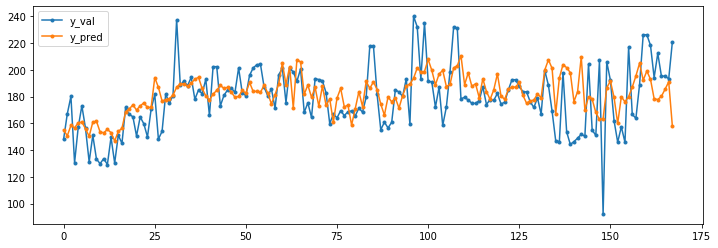

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 17.7783	valid_0's l2: 864.631
[2000]	valid_0's l1: 18.1106	valid_0's l2: 872.603
[3000]	valid_0's l1: 18.3761	valid_0's l2: 883.357
[4000]	valid_0's l1: 18.5531	valid_0's l2: 895.473
[5000]	valid_0's l1: 18.7769	valid_0's l2: 911.95
[6000]	valid_0's l1: 19.0386	valid_0's l2: 928.278
[7000]	valid_0's l1: 19.2133	valid_0's l2: 941.439
[8000]	valid_0's l1: 19.3981	valid_0's l2: 952.847
[9000]	valid_0's l1: 19.5345	valid_0's l2: 963.156
[10000]	valid_0's l1: 19.6555	valid_0's l2: 971.943
[11000]	valid_0's l1: 19.7318	valid_0's l2: 978.638
[12000]	valid_0's l1: 19.785	valid_0's l2: 984.908
[13000]	valid_0's l1: 19.8768	valid_0's l2: 994.622
[14000]	valid_0's l1: 19.9867	valid_0's l2: 1006.3
[15000]	valid_0's l1: 20.0742	valid_0's l2: 1016.03
[16000]	valid_0's l1: 20.1557	valid_0's l2: 1025.36
[17000]	valid_0's l1: 20.2133	valid_0's l2: 1033.49
[18000]	valid_0's l1: 20.2818	valid_0's l2: 1042.53
[19000]	vali

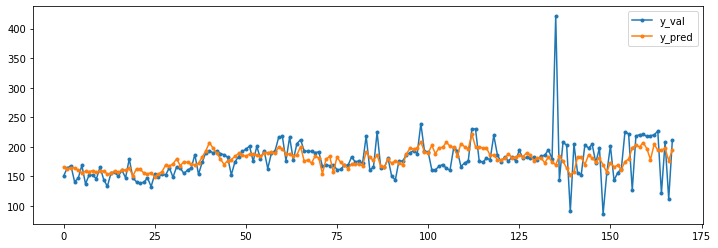

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.069	valid_0's l2: 482.153
[2000]	valid_0's l1: 15.4697	valid_0's l2: 471.858
[3000]	valid_0's l1: 15.5088	valid_0's l2: 480.06
[4000]	valid_0's l1: 15.5595	valid_0's l2: 484.575
[5000]	valid_0's l1: 15.7641	valid_0's l2: 490.658
[6000]	valid_0's l1: 15.9214	valid_0's l2: 494.064
[7000]	valid_0's l1: 15.9682	valid_0's l2: 497.019
[8000]	valid_0's l1: 16.0305	valid_0's l2: 501.66
[9000]	valid_0's l1: 16.1183	valid_0's l2: 506.498
[10000]	valid_0's l1: 16.2001	valid_0's l2: 510.572
[11000]	valid_0's l1: 16.2669	valid_0's l2: 512.823
[12000]	valid_0's l1: 16.2874	valid_0's l2: 514.488
[13000]	valid_0's l1: 16.3211	valid_0's l2: 516.765
[14000]	valid_0's l1: 16.3523	valid_0's l2: 518.82
[15000]	valid_0's l1: 16.3663	valid_0's l2: 520.32
[16000]	valid_0's l1: 16.3854	valid_0's l2: 521.852
[17000]	valid_0's l1: 16.4186	valid_0's l2: 524.417
[18000]	valid_0's l1: 16.4434	valid_0's l2: 526.07
[19000]	valid_0

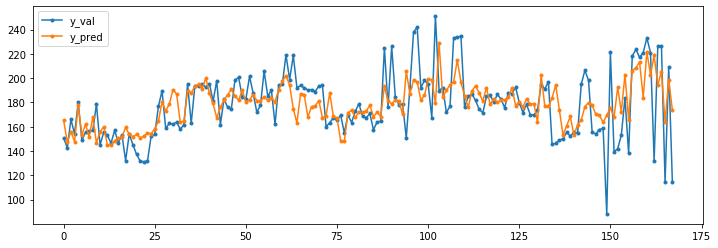

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.8631	valid_0's l2: 1464.9
[2000]	valid_0's l1: 16.9721	valid_0's l2: 1467.3
[3000]	valid_0's l1: 17.081	valid_0's l2: 1479.07
[4000]	valid_0's l1: 17.2533	valid_0's l2: 1495.69
[5000]	valid_0's l1: 17.298	valid_0's l2: 1506.39
[6000]	valid_0's l1: 17.3586	valid_0's l2: 1514.22
[7000]	valid_0's l1: 17.4058	valid_0's l2: 1524.93
[8000]	valid_0's l1: 17.4111	valid_0's l2: 1530.69
[9000]	valid_0's l1: 17.4593	valid_0's l2: 1537.62
[10000]	valid_0's l1: 17.523	valid_0's l2: 1542.57
[11000]	valid_0's l1: 17.5698	valid_0's l2: 1544.86
[12000]	valid_0's l1: 17.6584	valid_0's l2: 1546.97
[13000]	valid_0's l1: 17.7358	valid_0's l2: 1548.8
[14000]	valid_0's l1: 17.8206	valid_0's l2: 1552.05
[15000]	valid_0's l1: 17.9011	valid_0's l2: 1556.04
[16000]	valid_0's l1: 17.9616	valid_0's l2: 1559.45
[17000]	valid_0's l1: 18.0076	valid_0's l2: 1561.42
[18000]	valid_0's l1: 18.0463	valid_0's l2: 1564.22
[19000]	valid_0

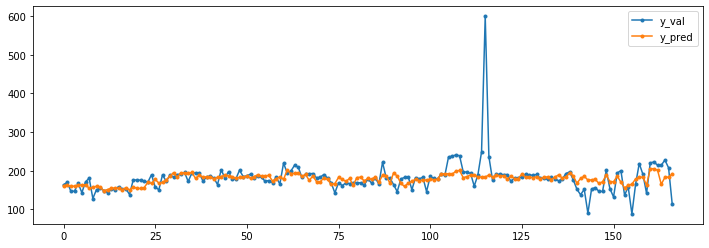

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.1794	valid_0's l2: 469.084
[2000]	valid_0's l1: 16.0862	valid_0's l2: 471.045
[3000]	valid_0's l1: 16.3695	valid_0's l2: 483.935
[4000]	valid_0's l1: 16.5589	valid_0's l2: 490.817
[5000]	valid_0's l1: 16.6707	valid_0's l2: 494.246
[6000]	valid_0's l1: 16.8412	valid_0's l2: 499.268
[7000]	valid_0's l1: 17.0114	valid_0's l2: 506.263
[8000]	valid_0's l1: 17.1519	valid_0's l2: 511.887
[9000]	valid_0's l1: 17.2238	valid_0's l2: 515.739
[10000]	valid_0's l1: 17.2788	valid_0's l2: 518.488
[11000]	valid_0's l1: 17.331	valid_0's l2: 522.557
[12000]	valid_0's l1: 17.3974	valid_0's l2: 527.283
[13000]	valid_0's l1: 17.4745	valid_0's l2: 532.652
[14000]	valid_0's l1: 17.5501	valid_0's l2: 537.427
[15000]	valid_0's l1: 17.5929	valid_0's l2: 540.92
[16000]	valid_0's l1: 17.6428	valid_0's l2: 544.75
[17000]	valid_0's l1: 17.6766	valid_0's l2: 547.997
[18000]	valid_0's l1: 17.7058	valid_0's l2: 550.754
[19000]	vali

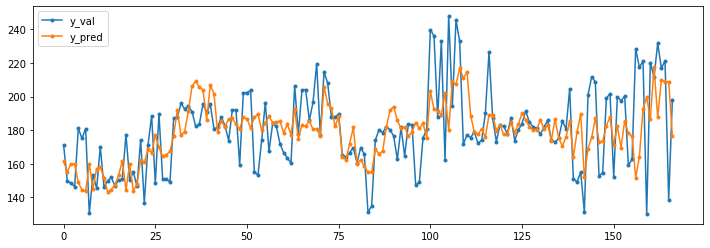

(16.30358919067452, 737.9417793904057)
train column :  smp_mean
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 8.33814	valid_0's l2: 157.596
[2000]	valid_0's l1: 7.6614	valid_0's l2: 142.571
[3000]	valid_0's l1: 7.71286	valid_0's l2: 140.091
[4000]	valid_0's l1: 7.82423	valid_0's l2: 140.539
[5000]	valid_0's l1: 7.89629	valid_0's l2: 139.189
[6000]	valid_0's l1: 8.03562	valid_0's l2: 141.896
[7000]	valid_0's l1: 8.12004	valid_0's l2: 144.179
[8000]	valid_0's l1: 8.20177	valid_0's l2: 145.334
[9000]	valid_0's l1: 8.26104	valid_0's l2: 145.981
[10000]	valid_0's l1: 8.2946	valid_0's l2: 146.612
[11000]	valid_0's l1: 8.34795	valid_0's l2: 147.569
[12000]	valid_0's l1: 8.39093	valid_0's l2: 148.437
[13000]	valid_0's l1: 8.42612	valid_0's l2: 149.157
[14000]	valid_0's l1: 8.45329	valid_0's l2: 149.746
[15000]	valid_0's l1: 8.4798	valid_0's l2: 150.152
[16000]	valid_0's l1: 8.50434	valid_0's l2: 150.531
[17000]	valid_0's l1: 8.52432	valid_0's l2: 150.785


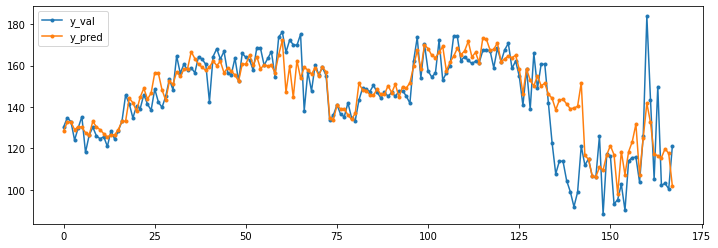

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 7.09598	valid_0's l2: 123.864
[2000]	valid_0's l1: 6.80471	valid_0's l2: 110.465
[3000]	valid_0's l1: 6.80189	valid_0's l2: 109.016
[4000]	valid_0's l1: 6.95079	valid_0's l2: 110.644
[5000]	valid_0's l1: 7.0006	valid_0's l2: 111.579
[6000]	valid_0's l1: 7.05859	valid_0's l2: 112.362
[7000]	valid_0's l1: 7.1443	valid_0's l2: 114.481
[8000]	valid_0's l1: 7.22976	valid_0's l2: 116.071
[9000]	valid_0's l1: 7.29204	valid_0's l2: 117.463
[10000]	valid_0's l1: 7.33921	valid_0's l2: 118.359
[11000]	valid_0's l1: 7.39036	valid_0's l2: 119.528
[12000]	valid_0's l1: 7.42169	valid_0's l2: 120.232
[13000]	valid_0's l1: 7.44251	valid_0's l2: 120.704
[14000]	valid_0's l1: 7.47244	valid_0's l2: 121.317
[15000]	valid_0's l1: 7.48588	valid_0's l2: 121.618
[16000]	valid_0's l1: 7.50213	valid_0's l2: 121.903
[17000]	valid_0's l1: 7.52194	valid_0's l2: 122.182
[18000]	valid_0's l1: 7.53172	valid_0's l2: 122.459
[19000]	val

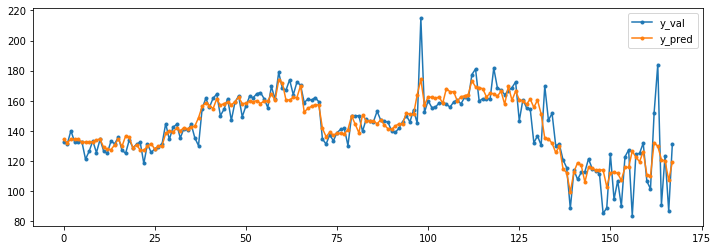

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 8.10263	valid_0's l2: 158.913
[2000]	valid_0's l1: 7.85968	valid_0's l2: 148.198
[3000]	valid_0's l1: 7.98323	valid_0's l2: 146.735
[4000]	valid_0's l1: 8.05534	valid_0's l2: 146.397
[5000]	valid_0's l1: 8.08484	valid_0's l2: 146.298
[6000]	valid_0's l1: 8.11025	valid_0's l2: 147.256
[7000]	valid_0's l1: 8.14714	valid_0's l2: 148.105
[8000]	valid_0's l1: 8.21102	valid_0's l2: 149.622
[9000]	valid_0's l1: 8.26176	valid_0's l2: 151.026
[10000]	valid_0's l1: 8.31207	valid_0's l2: 152.009
[11000]	valid_0's l1: 8.34992	valid_0's l2: 152.645
[12000]	valid_0's l1: 8.37845	valid_0's l2: 153.1
[13000]	valid_0's l1: 8.40582	valid_0's l2: 153.465
[14000]	valid_0's l1: 8.41918	valid_0's l2: 153.497
[15000]	valid_0's l1: 8.43562	valid_0's l2: 153.892
[16000]	valid_0's l1: 8.44737	valid_0's l2: 154.17
[17000]	valid_0's l1: 8.46113	valid_0's l2: 154.464
[18000]	valid_0's l1: 8.46879	valid_0's l2: 154.683
[19000]	vali

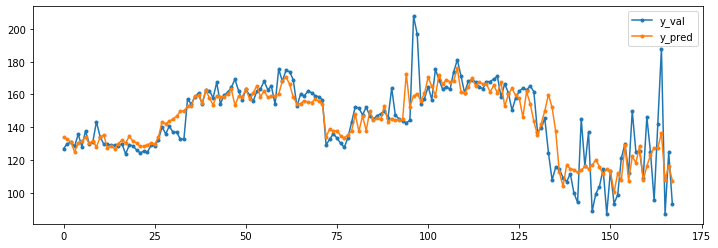

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 6.98213	valid_0's l2: 113.825
[2000]	valid_0's l1: 6.07281	valid_0's l2: 85.6467
[3000]	valid_0's l1: 6.02396	valid_0's l2: 82.7061
[4000]	valid_0's l1: 6.10775	valid_0's l2: 81.4724
[5000]	valid_0's l1: 6.22045	valid_0's l2: 82.1895
[6000]	valid_0's l1: 6.28112	valid_0's l2: 82.3337
[7000]	valid_0's l1: 6.35101	valid_0's l2: 83.0566
[8000]	valid_0's l1: 6.42086	valid_0's l2: 83.9908
[9000]	valid_0's l1: 6.4736	valid_0's l2: 84.5908
[10000]	valid_0's l1: 6.54969	valid_0's l2: 85.5369
[11000]	valid_0's l1: 6.6081	valid_0's l2: 86.2859
[12000]	valid_0's l1: 6.64921	valid_0's l2: 86.8605
[13000]	valid_0's l1: 6.68328	valid_0's l2: 87.4544
[14000]	valid_0's l1: 6.70486	valid_0's l2: 87.8328
[15000]	valid_0's l1: 6.71465	valid_0's l2: 87.9879
[16000]	valid_0's l1: 6.72581	valid_0's l2: 88.1952
[17000]	valid_0's l1: 6.7366	valid_0's l2: 88.3345
[18000]	valid_0's l1: 6.73997	valid_0's l2: 88.2713
[19000]	vali

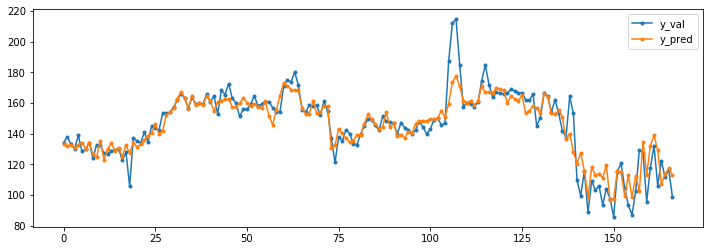

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 7.21677	valid_0's l2: 112.428
[2000]	valid_0's l1: 6.85066	valid_0's l2: 108.098
[3000]	valid_0's l1: 6.94635	valid_0's l2: 110.516
[4000]	valid_0's l1: 6.97401	valid_0's l2: 111.202
[5000]	valid_0's l1: 7.06509	valid_0's l2: 112.698
[6000]	valid_0's l1: 7.10583	valid_0's l2: 113.531
[7000]	valid_0's l1: 7.12074	valid_0's l2: 113.481
[8000]	valid_0's l1: 7.14815	valid_0's l2: 113.733
[9000]	valid_0's l1: 7.15903	valid_0's l2: 113.79
[10000]	valid_0's l1: 7.16818	valid_0's l2: 113.907
[11000]	valid_0's l1: 7.17107	valid_0's l2: 113.904
[12000]	valid_0's l1: 7.18743	valid_0's l2: 114.23
[13000]	valid_0's l1: 7.19182	valid_0's l2: 114.3
[14000]	valid_0's l1: 7.19862	valid_0's l2: 114.336
[15000]	valid_0's l1: 7.20354	valid_0's l2: 114.429
[16000]	valid_0's l1: 7.21566	valid_0's l2: 114.675
[17000]	valid_0's l1: 7.22817	valid_0's l2: 114.897
[18000]	valid_0's l1: 7.23976	valid_0's l2: 115.146
[19000]	valid

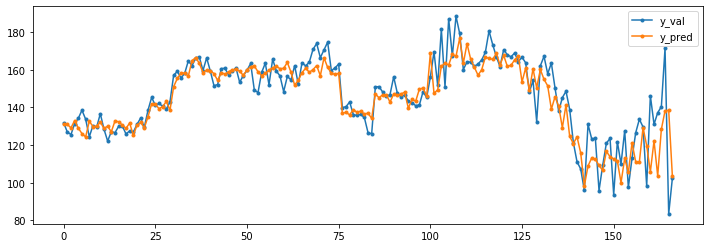

(6.984153321889781, 118.6382443798755)


In [294]:
x_train = target.loc[:, new_x_columns]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]
scores_l1 = []
scores_l2 = []
smp_models = {}
k = 5

for label in y_train.columns:
    print('train column : ', label)
    smp_models[label], scores = create_model(x_train, y_train[label], k=k)
    
    scores_l1.append(scores[0])
    scores_l2.append(scores[1])
    
    print(scores)
    print('==========================================================================')

In [295]:
print(sum(scores_l1) / len(scores_l1))
print(sum(scores_l2) / len(scores_l2))

11.012311169264487
366.5074201707037


In [296]:
x_test = test.loc[:,new_x_columns]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    
    for model in smp_models[label]:
        preds.append(model.predict(x_test))
    test[label] = sum(preds) / len(preds)

### submission_top_half

In [297]:
submission_top_half.loc[:, 'supply'] = list(target.loc[736:763, 'supply'])
x_prev_test = target.loc[736:763, new_x_columns].copy()

for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    
    for model in smp_models[label]:
        preds.append(model.predict(x_prev_test))
    
    submission_top_half[label] = sum(preds) / len(preds)

In [298]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = \
        test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission_top_half, submission], axis = 0)

display(submission)

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,190.133561,83.494834,116.249759,84.370000
1,2020-02-08,163.491856,81.369449,111.790029,84.110000
2,2020-02-09,165.007757,80.470063,111.684722,82.410000
3,2020-02-10,178.102080,84.365653,113.445631,83.300000
4,2020-02-11,183.864367,85.400221,114.384794,75.870000
...,...,...,...,...,...
51,2020-06-17,201.368426,70.183358,157.350633,68.786199
52,2020-06-18,202.318204,70.722320,159.826229,67.381350
53,2020-06-19,201.561412,70.050977,158.380157,66.434510
54,2020-06-20,194.651225,69.940136,155.661964,64.181679


In [299]:
submission.to_csv('EDA_FS_002_50000.csv', index=False)

# Delete

In [300]:
def create_model(x_data, y_data, k=5):
    models = []
    scores_l1 = []
    scores_l2 = []
    params = {
        'metric': ['mae', 'mse'],
        'seed':777,
        'learning_rate' : 0.002
    }
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=77)
   
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = lgb.Dataset(x_train, y_train)
        d_val = lgb.Dataset(x_val, y_val)

        model = lgb.train(params, d_train, 50000, d_val, \
                          verbose_eval=1000, \
                          early_stopping_rounds=50000)
        
        pred = model.predict(x_val)
        plt.rcParams['figure.figsize'] = [12, 4]
        plt.plot(np.array(y_val), '.-', label='y_val')
        plt.plot(pred, '.-', label='y_pred')
        plt.legend()
        plt.show()
        
        models.append(model)
        
        score_l1 = dict(model.best_score)['valid_0']['l1']
        score_l2 = dict(model.best_score)['valid_0']['l2']
        
        scores_l1.append(score_l1)
        scores_l2.append(score_l2)
        
    return models, (sum(scores_l1) / len(scores_l1), sum(scores_l2)/ len(scores_l2))

In [301]:
x_columns = origin_x_columns

train column :  smp_min
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 12.1216	valid_0's l2: 316.174
[2000]	valid_0's l1: 11.3074	valid_0's l2: 324.653
[3000]	valid_0's l1: 11.4172	valid_0's l2: 329.641
[4000]	valid_0's l1: 11.5144	valid_0's l2: 330.248
[5000]	valid_0's l1: 11.6634	valid_0's l2: 331.053
[6000]	valid_0's l1: 11.7627	valid_0's l2: 331.692
[7000]	valid_0's l1: 11.8744	valid_0's l2: 333.382
[8000]	valid_0's l1: 11.9461	valid_0's l2: 334.071
[9000]	valid_0's l1: 11.9917	valid_0's l2: 333.303
[10000]	valid_0's l1: 12.0352	valid_0's l2: 333.84
[11000]	valid_0's l1: 12.0781	valid_0's l2: 334.278
[12000]	valid_0's l1: 12.1231	valid_0's l2: 335.402
[13000]	valid_0's l1: 12.1525	valid_0's l2: 335.598
[14000]	valid_0's l1: 12.1765	valid_0's l2: 335.793
[15000]	valid_0's l1: 12.1898	valid_0's l2: 336.193
[16000]	valid_0's l1: 12.2111	valid_0's l2: 336.87
[17000]	valid_0's l1: 12.2222	valid_0's l2: 337.25
[18000]	valid_0's l1: 12.2354	valid_0's 

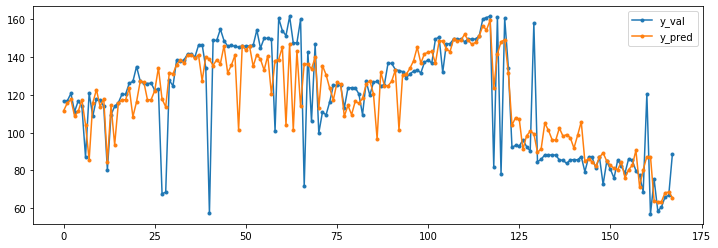

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 11.3341	valid_0's l2: 288.695
[2000]	valid_0's l1: 10.3513	valid_0's l2: 277.197
[3000]	valid_0's l1: 10.4813	valid_0's l2: 277.509
[4000]	valid_0's l1: 10.662	valid_0's l2: 280.393
[5000]	valid_0's l1: 10.7838	valid_0's l2: 281.046
[6000]	valid_0's l1: 10.9104	valid_0's l2: 282.444
[7000]	valid_0's l1: 11.0324	valid_0's l2: 285.484
[8000]	valid_0's l1: 11.0689	valid_0's l2: 286.971
[9000]	valid_0's l1: 11.1171	valid_0's l2: 288.653
[10000]	valid_0's l1: 11.1593	valid_0's l2: 289.828
[11000]	valid_0's l1: 11.2063	valid_0's l2: 291.344
[12000]	valid_0's l1: 11.2255	valid_0's l2: 291.853
[13000]	valid_0's l1: 11.2544	valid_0's l2: 292.408
[14000]	valid_0's l1: 11.2773	valid_0's l2: 293.002
[15000]	valid_0's l1: 11.3021	valid_0's l2: 293.961
[16000]	valid_0's l1: 11.3395	valid_0's l2: 295.367
[17000]	valid_0's l1: 11.3668	valid_0's l2: 296.586
[18000]	valid_0's l1: 11.3923	valid_0's l2: 297.674
[19000]	va

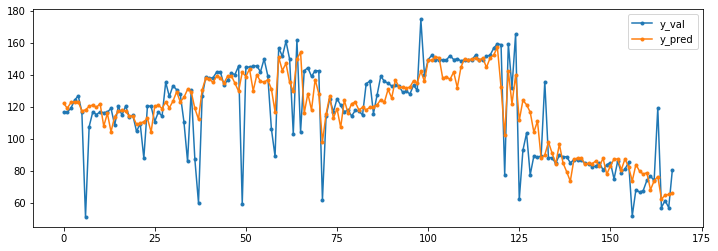

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 11.2788	valid_0's l2: 282.375
[2000]	valid_0's l1: 10.3787	valid_0's l2: 285.997
[3000]	valid_0's l1: 10.6661	valid_0's l2: 294.212
[4000]	valid_0's l1: 10.9483	valid_0's l2: 303.479
[5000]	valid_0's l1: 11.0788	valid_0's l2: 308.842
[6000]	valid_0's l1: 11.1955	valid_0's l2: 314.521
[7000]	valid_0's l1: 11.3246	valid_0's l2: 318.345
[8000]	valid_0's l1: 11.4389	valid_0's l2: 321.59
[9000]	valid_0's l1: 11.54	valid_0's l2: 325.273
[10000]	valid_0's l1: 11.6491	valid_0's l2: 328.644
[11000]	valid_0's l1: 11.7307	valid_0's l2: 330.785
[12000]	valid_0's l1: 11.7717	valid_0's l2: 332.287
[13000]	valid_0's l1: 11.8286	valid_0's l2: 333.99
[14000]	valid_0's l1: 11.8659	valid_0's l2: 335.236
[15000]	valid_0's l1: 11.8925	valid_0's l2: 336.213
[16000]	valid_0's l1: 11.915	valid_0's l2: 336.98
[17000]	valid_0's l1: 11.9429	valid_0's l2: 337.945
[18000]	valid_0's l1: 11.963	valid_0's l2: 338.647
[19000]	valid_0'

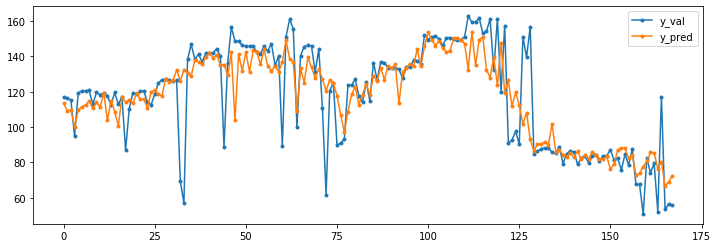

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 9.55396	valid_0's l2: 192.298
[2000]	valid_0's l1: 8.26021	valid_0's l2: 160.782
[3000]	valid_0's l1: 8.22583	valid_0's l2: 157.477
[4000]	valid_0's l1: 8.327	valid_0's l2: 155.929
[5000]	valid_0's l1: 8.41114	valid_0's l2: 155.687
[6000]	valid_0's l1: 8.47698	valid_0's l2: 155.763
[7000]	valid_0's l1: 8.5375	valid_0's l2: 155.973
[8000]	valid_0's l1: 8.57565	valid_0's l2: 156.44
[9000]	valid_0's l1: 8.62835	valid_0's l2: 156.921
[10000]	valid_0's l1: 8.65507	valid_0's l2: 157.085
[11000]	valid_0's l1: 8.69537	valid_0's l2: 156.929
[12000]	valid_0's l1: 8.72516	valid_0's l2: 157.256
[13000]	valid_0's l1: 8.75151	valid_0's l2: 157.56
[14000]	valid_0's l1: 8.77487	valid_0's l2: 157.688
[15000]	valid_0's l1: 8.79098	valid_0's l2: 157.539
[16000]	valid_0's l1: 8.80465	valid_0's l2: 157.446
[17000]	valid_0's l1: 8.82558	valid_0's l2: 157.709
[18000]	valid_0's l1: 8.83941	valid_0's l2: 157.846
[19000]	valid_

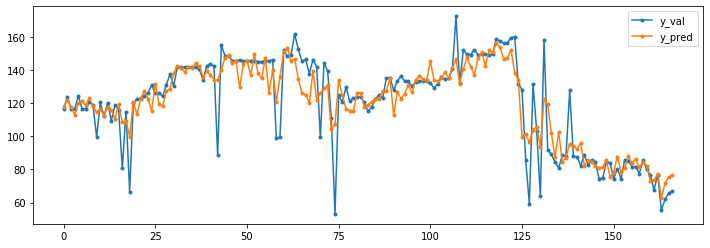

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 9.3952	valid_0's l2: 180.112
[2000]	valid_0's l1: 8.55015	valid_0's l2: 170.854
[3000]	valid_0's l1: 8.63246	valid_0's l2: 171.07
[4000]	valid_0's l1: 8.72618	valid_0's l2: 170.327
[5000]	valid_0's l1: 8.78936	valid_0's l2: 171.791
[6000]	valid_0's l1: 8.87935	valid_0's l2: 172.131
[7000]	valid_0's l1: 8.93804	valid_0's l2: 172.623
[8000]	valid_0's l1: 8.93919	valid_0's l2: 172.891
[9000]	valid_0's l1: 8.99923	valid_0's l2: 174.059
[10000]	valid_0's l1: 9.0197	valid_0's l2: 174.377
[11000]	valid_0's l1: 9.06511	valid_0's l2: 175.4
[12000]	valid_0's l1: 9.09247	valid_0's l2: 175.661
[13000]	valid_0's l1: 9.1097	valid_0's l2: 176.035
[14000]	valid_0's l1: 9.13242	valid_0's l2: 176.255
[15000]	valid_0's l1: 9.16076	valid_0's l2: 176.674
[16000]	valid_0's l1: 9.19209	valid_0's l2: 177.243
[17000]	valid_0's l1: 9.22059	valid_0's l2: 177.917
[18000]	valid_0's l1: 9.22577	valid_0's l2: 177.871
[19000]	valid_0

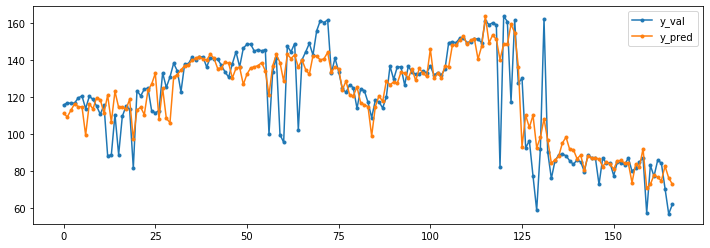

(9.74919099522917, 242.94223674183007)
train column :  smp_max
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 15.6459	valid_0's l2: 423.979
[2000]	valid_0's l1: 15.6648	valid_0's l2: 433.829
[3000]	valid_0's l1: 15.8479	valid_0's l2: 448.507
[4000]	valid_0's l1: 16.0148	valid_0's l2: 458.988
[5000]	valid_0's l1: 16.1304	valid_0's l2: 467.667
[6000]	valid_0's l1: 16.1635	valid_0's l2: 474.62
[7000]	valid_0's l1: 16.2436	valid_0's l2: 482.689
[8000]	valid_0's l1: 16.3625	valid_0's l2: 491.546
[9000]	valid_0's l1: 16.5194	valid_0's l2: 501.466
[10000]	valid_0's l1: 16.651	valid_0's l2: 510.931
[11000]	valid_0's l1: 16.7759	valid_0's l2: 520.819
[12000]	valid_0's l1: 16.8399	valid_0's l2: 528.098
[13000]	valid_0's l1: 16.9166	valid_0's l2: 536.841
[14000]	valid_0's l1: 16.9705	valid_0's l2: 544.32
[15000]	valid_0's l1: 17.0373	valid_0's l2: 551.114
[16000]	valid_0's l1: 17.0891	valid_0's l2: 557.87
[17000]	valid_0's l1: 17.1253	valid_0's l2: 563.878
[1

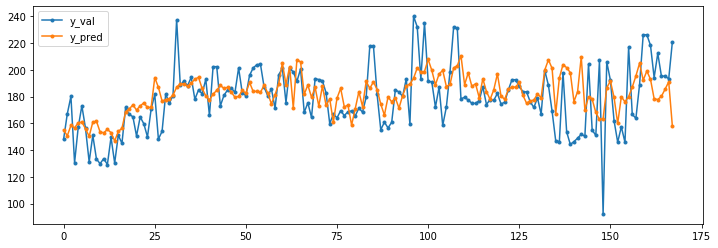

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 17.7783	valid_0's l2: 864.631
[2000]	valid_0's l1: 18.1106	valid_0's l2: 872.603
[3000]	valid_0's l1: 18.3761	valid_0's l2: 883.357
[4000]	valid_0's l1: 18.5531	valid_0's l2: 895.473
[5000]	valid_0's l1: 18.7769	valid_0's l2: 911.95
[6000]	valid_0's l1: 19.0386	valid_0's l2: 928.278
[7000]	valid_0's l1: 19.2133	valid_0's l2: 941.439
[8000]	valid_0's l1: 19.3981	valid_0's l2: 952.847
[9000]	valid_0's l1: 19.5345	valid_0's l2: 963.156
[10000]	valid_0's l1: 19.6555	valid_0's l2: 971.943
[11000]	valid_0's l1: 19.7318	valid_0's l2: 978.638
[12000]	valid_0's l1: 19.785	valid_0's l2: 984.908
[13000]	valid_0's l1: 19.8768	valid_0's l2: 994.622
[14000]	valid_0's l1: 19.9867	valid_0's l2: 1006.3
[15000]	valid_0's l1: 20.0742	valid_0's l2: 1016.03
[16000]	valid_0's l1: 20.1557	valid_0's l2: 1025.36
[17000]	valid_0's l1: 20.2133	valid_0's l2: 1033.49
[18000]	valid_0's l1: 20.2818	valid_0's l2: 1042.53
[19000]	vali

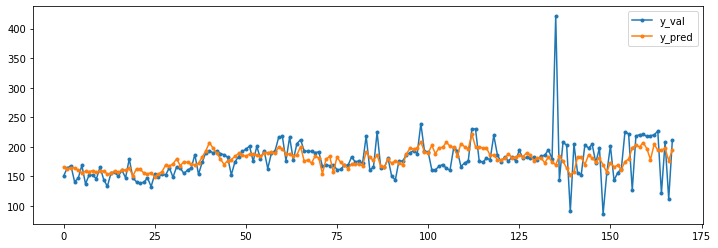

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.069	valid_0's l2: 482.153
[2000]	valid_0's l1: 15.4697	valid_0's l2: 471.858
[3000]	valid_0's l1: 15.5088	valid_0's l2: 480.06
[4000]	valid_0's l1: 15.5595	valid_0's l2: 484.575
[5000]	valid_0's l1: 15.7641	valid_0's l2: 490.658
[6000]	valid_0's l1: 15.9214	valid_0's l2: 494.064
[7000]	valid_0's l1: 15.9682	valid_0's l2: 497.019
[8000]	valid_0's l1: 16.0305	valid_0's l2: 501.66
[9000]	valid_0's l1: 16.1183	valid_0's l2: 506.498
[10000]	valid_0's l1: 16.2001	valid_0's l2: 510.572
[11000]	valid_0's l1: 16.2669	valid_0's l2: 512.823
[12000]	valid_0's l1: 16.2874	valid_0's l2: 514.488
[13000]	valid_0's l1: 16.3211	valid_0's l2: 516.765
[14000]	valid_0's l1: 16.3523	valid_0's l2: 518.82
[15000]	valid_0's l1: 16.3663	valid_0's l2: 520.32
[16000]	valid_0's l1: 16.3854	valid_0's l2: 521.852
[17000]	valid_0's l1: 16.4186	valid_0's l2: 524.417
[18000]	valid_0's l1: 16.4434	valid_0's l2: 526.07
[19000]	valid_0

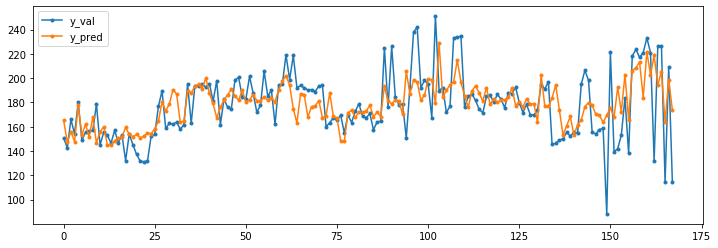

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.8631	valid_0's l2: 1464.9
[2000]	valid_0's l1: 16.9721	valid_0's l2: 1467.3
[3000]	valid_0's l1: 17.081	valid_0's l2: 1479.07
[4000]	valid_0's l1: 17.2533	valid_0's l2: 1495.69
[5000]	valid_0's l1: 17.298	valid_0's l2: 1506.39
[6000]	valid_0's l1: 17.3586	valid_0's l2: 1514.22
[7000]	valid_0's l1: 17.4058	valid_0's l2: 1524.93
[8000]	valid_0's l1: 17.4111	valid_0's l2: 1530.69
[9000]	valid_0's l1: 17.4593	valid_0's l2: 1537.62
[10000]	valid_0's l1: 17.523	valid_0's l2: 1542.57
[11000]	valid_0's l1: 17.5698	valid_0's l2: 1544.86
[12000]	valid_0's l1: 17.6584	valid_0's l2: 1546.97
[13000]	valid_0's l1: 17.7358	valid_0's l2: 1548.8
[14000]	valid_0's l1: 17.8206	valid_0's l2: 1552.05
[15000]	valid_0's l1: 17.9011	valid_0's l2: 1556.04
[16000]	valid_0's l1: 17.9616	valid_0's l2: 1559.45
[17000]	valid_0's l1: 18.0076	valid_0's l2: 1561.42
[18000]	valid_0's l1: 18.0463	valid_0's l2: 1564.22
[19000]	valid_0

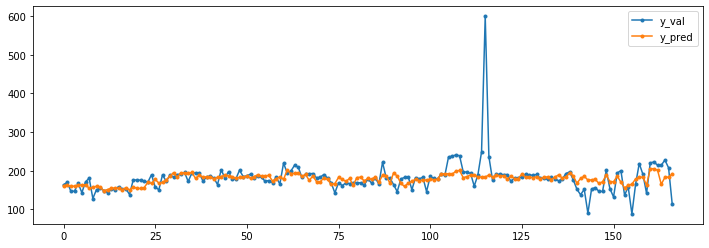

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 16.1794	valid_0's l2: 469.084
[2000]	valid_0's l1: 16.0862	valid_0's l2: 471.045
[3000]	valid_0's l1: 16.3695	valid_0's l2: 483.935
[4000]	valid_0's l1: 16.5589	valid_0's l2: 490.817
[5000]	valid_0's l1: 16.6707	valid_0's l2: 494.246
[6000]	valid_0's l1: 16.8412	valid_0's l2: 499.268
[7000]	valid_0's l1: 17.0114	valid_0's l2: 506.263
[8000]	valid_0's l1: 17.1519	valid_0's l2: 511.887
[9000]	valid_0's l1: 17.2238	valid_0's l2: 515.739
[10000]	valid_0's l1: 17.2788	valid_0's l2: 518.488
[11000]	valid_0's l1: 17.331	valid_0's l2: 522.557
[12000]	valid_0's l1: 17.3974	valid_0's l2: 527.283
[13000]	valid_0's l1: 17.4745	valid_0's l2: 532.652
[14000]	valid_0's l1: 17.5501	valid_0's l2: 537.427
[15000]	valid_0's l1: 17.5929	valid_0's l2: 540.92
[16000]	valid_0's l1: 17.6428	valid_0's l2: 544.75
[17000]	valid_0's l1: 17.6766	valid_0's l2: 547.997
[18000]	valid_0's l1: 17.7058	valid_0's l2: 550.754
[19000]	vali

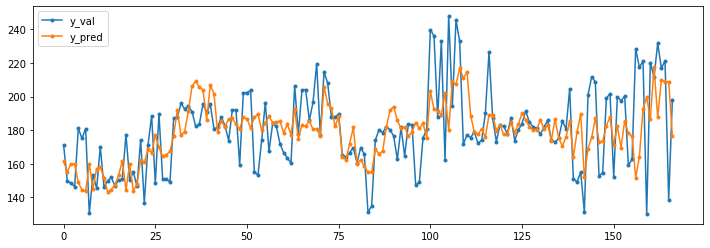

(16.30358919067452, 737.9417793904057)
train column :  smp_mean
Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 8.33814	valid_0's l2: 157.596
[2000]	valid_0's l1: 7.6614	valid_0's l2: 142.571
[3000]	valid_0's l1: 7.71286	valid_0's l2: 140.091
[4000]	valid_0's l1: 7.82423	valid_0's l2: 140.539
[5000]	valid_0's l1: 7.89629	valid_0's l2: 139.189
[6000]	valid_0's l1: 8.03562	valid_0's l2: 141.896
[7000]	valid_0's l1: 8.12004	valid_0's l2: 144.179
[8000]	valid_0's l1: 8.20177	valid_0's l2: 145.334
[9000]	valid_0's l1: 8.26104	valid_0's l2: 145.981
[10000]	valid_0's l1: 8.2946	valid_0's l2: 146.612
[11000]	valid_0's l1: 8.34795	valid_0's l2: 147.569
[12000]	valid_0's l1: 8.39093	valid_0's l2: 148.437
[13000]	valid_0's l1: 8.42612	valid_0's l2: 149.157
[14000]	valid_0's l1: 8.45329	valid_0's l2: 149.746
[15000]	valid_0's l1: 8.4798	valid_0's l2: 150.152
[16000]	valid_0's l1: 8.50434	valid_0's l2: 150.531
[17000]	valid_0's l1: 8.52432	valid_0's l2: 150.785


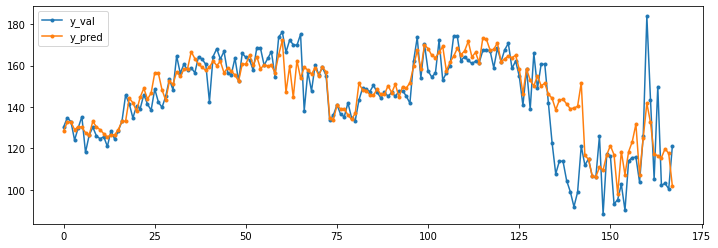

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 7.09598	valid_0's l2: 123.864
[2000]	valid_0's l1: 6.80471	valid_0's l2: 110.465
[3000]	valid_0's l1: 6.80189	valid_0's l2: 109.016
[4000]	valid_0's l1: 6.95079	valid_0's l2: 110.644
[5000]	valid_0's l1: 7.0006	valid_0's l2: 111.579
[6000]	valid_0's l1: 7.05859	valid_0's l2: 112.362
[7000]	valid_0's l1: 7.1443	valid_0's l2: 114.481
[8000]	valid_0's l1: 7.22976	valid_0's l2: 116.071
[9000]	valid_0's l1: 7.29204	valid_0's l2: 117.463
[10000]	valid_0's l1: 7.33921	valid_0's l2: 118.359
[11000]	valid_0's l1: 7.39036	valid_0's l2: 119.528
[12000]	valid_0's l1: 7.42169	valid_0's l2: 120.232
[13000]	valid_0's l1: 7.44251	valid_0's l2: 120.704
[14000]	valid_0's l1: 7.47244	valid_0's l2: 121.317
[15000]	valid_0's l1: 7.48588	valid_0's l2: 121.618
[16000]	valid_0's l1: 7.50213	valid_0's l2: 121.903
[17000]	valid_0's l1: 7.52194	valid_0's l2: 122.182
[18000]	valid_0's l1: 7.53172	valid_0's l2: 122.459
[19000]	val

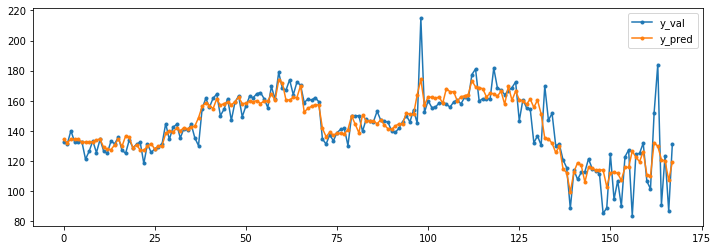

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 8.10263	valid_0's l2: 158.913
[2000]	valid_0's l1: 7.85968	valid_0's l2: 148.198
[3000]	valid_0's l1: 7.98323	valid_0's l2: 146.735
[4000]	valid_0's l1: 8.05534	valid_0's l2: 146.397
[5000]	valid_0's l1: 8.08484	valid_0's l2: 146.298
[6000]	valid_0's l1: 8.11025	valid_0's l2: 147.256
[7000]	valid_0's l1: 8.14714	valid_0's l2: 148.105
[8000]	valid_0's l1: 8.21102	valid_0's l2: 149.622
[9000]	valid_0's l1: 8.26176	valid_0's l2: 151.026
[10000]	valid_0's l1: 8.31207	valid_0's l2: 152.009
[11000]	valid_0's l1: 8.34992	valid_0's l2: 152.645
[12000]	valid_0's l1: 8.37845	valid_0's l2: 153.1
[13000]	valid_0's l1: 8.40582	valid_0's l2: 153.465
[14000]	valid_0's l1: 8.41918	valid_0's l2: 153.497
[15000]	valid_0's l1: 8.43562	valid_0's l2: 153.892
[16000]	valid_0's l1: 8.44737	valid_0's l2: 154.17
[17000]	valid_0's l1: 8.46113	valid_0's l2: 154.464
[18000]	valid_0's l1: 8.46879	valid_0's l2: 154.683
[19000]	vali

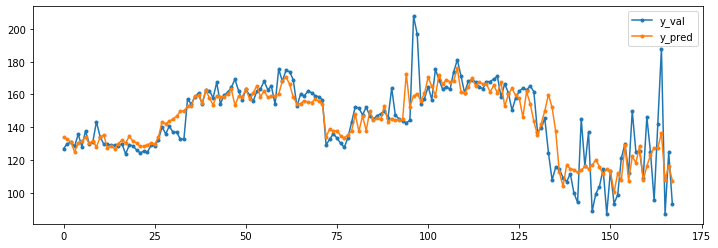

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 6.98213	valid_0's l2: 113.825
[2000]	valid_0's l1: 6.07281	valid_0's l2: 85.6467
[3000]	valid_0's l1: 6.02396	valid_0's l2: 82.7061
[4000]	valid_0's l1: 6.10775	valid_0's l2: 81.4724
[5000]	valid_0's l1: 6.22045	valid_0's l2: 82.1895
[6000]	valid_0's l1: 6.28112	valid_0's l2: 82.3337
[7000]	valid_0's l1: 6.35101	valid_0's l2: 83.0566
[8000]	valid_0's l1: 6.42086	valid_0's l2: 83.9908
[9000]	valid_0's l1: 6.4736	valid_0's l2: 84.5908
[10000]	valid_0's l1: 6.54969	valid_0's l2: 85.5369
[11000]	valid_0's l1: 6.6081	valid_0's l2: 86.2859
[12000]	valid_0's l1: 6.64921	valid_0's l2: 86.8605
[13000]	valid_0's l1: 6.68328	valid_0's l2: 87.4544
[14000]	valid_0's l1: 6.70486	valid_0's l2: 87.8328
[15000]	valid_0's l1: 6.71465	valid_0's l2: 87.9879
[16000]	valid_0's l1: 6.72581	valid_0's l2: 88.1952
[17000]	valid_0's l1: 6.7366	valid_0's l2: 88.3345
[18000]	valid_0's l1: 6.73997	valid_0's l2: 88.2713
[19000]	vali

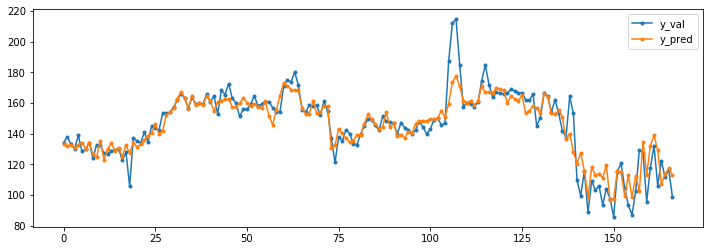

Training until validation scores don't improve for 50000 rounds
[1000]	valid_0's l1: 7.21677	valid_0's l2: 112.428
[2000]	valid_0's l1: 6.85066	valid_0's l2: 108.098
[3000]	valid_0's l1: 6.94635	valid_0's l2: 110.516
[4000]	valid_0's l1: 6.97401	valid_0's l2: 111.202
[5000]	valid_0's l1: 7.06509	valid_0's l2: 112.698
[6000]	valid_0's l1: 7.10583	valid_0's l2: 113.531
[7000]	valid_0's l1: 7.12074	valid_0's l2: 113.481
[8000]	valid_0's l1: 7.14815	valid_0's l2: 113.733
[9000]	valid_0's l1: 7.15903	valid_0's l2: 113.79
[10000]	valid_0's l1: 7.16818	valid_0's l2: 113.907
[11000]	valid_0's l1: 7.17107	valid_0's l2: 113.904
[12000]	valid_0's l1: 7.18743	valid_0's l2: 114.23
[13000]	valid_0's l1: 7.19182	valid_0's l2: 114.3
[14000]	valid_0's l1: 7.19862	valid_0's l2: 114.336
[15000]	valid_0's l1: 7.20354	valid_0's l2: 114.429
[16000]	valid_0's l1: 7.21566	valid_0's l2: 114.675
[17000]	valid_0's l1: 7.22817	valid_0's l2: 114.897
[18000]	valid_0's l1: 7.23976	valid_0's l2: 115.146
[19000]	valid

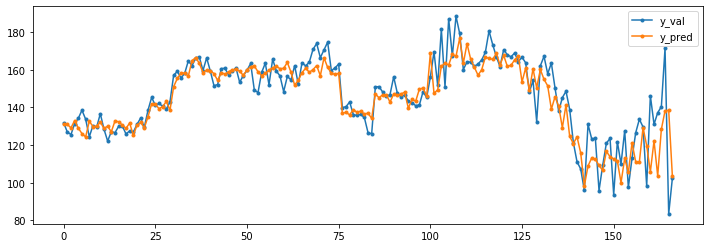

(6.984153321889781, 118.6382443798755)


In [302]:
x_train = target.loc[:, new_x_columns]
y_train = target.loc[:, ['smp_min', 'smp_max', 'smp_mean' ]]
scores_l1 = []
scores_l2 = []
smp_models = {}
k = 5

for label in y_train.columns:
    print('train column : ', label)
    smp_models[label], scores = create_model(x_train, y_train[label], k=k)
    
    scores_l1.append(scores[0])
    scores_l2.append(scores[1])
    
    print(scores)
    print('==========================================================================')

In [303]:
print(sum(scores_l1) / len(scores_l1))
print(sum(scores_l2) / len(scores_l2))

11.01231116926449
366.5074201707037


In [304]:
x_test = test.loc[:,new_x_columns]
for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    
    for model in smp_models[label]:
        preds.append(model.predict(x_test))
    test[label] = sum(preds) / len(preds)

In [305]:
submission_top_half.loc[:, 'supply'] = list(target.loc[736:763, 'supply'])
x_prev_test = target.loc[736:763, new_x_columns].copy()

for label in ['smp_min', 'smp_max', 'smp_mean']:
    preds = []
    
    for model in smp_models[label]:
        preds.append(model.predict(x_prev_test))
    
    submission_top_half[label] = sum(preds) / len(preds)

In [306]:
submission.loc[:, ['smp_min', 'smp_max', 'smp_mean', 'supply']] = \
        test.loc[:,['smp_min', 'smp_max', 'smp_mean', 'supply']]
submission = pd.concat([submission_top_half, submission], axis = 0)

display(submission)

,date,smp_max,smp_min,smp_mean,supply
0,2020-02-07,190.133561,83.494834,116.249759,84.370000
1,2020-02-08,163.491856,81.369449,111.790029,84.110000
2,2020-02-09,165.007757,80.470063,111.684722,82.410000
3,2020-02-10,178.102080,84.365653,113.445631,83.300000
4,2020-02-11,183.864367,85.400221,114.384794,75.870000
...,...,...,...,...,...
51,2020-06-17,201.368426,70.183358,157.350633,68.786199
52,2020-06-18,202.318204,70.722320,159.826229,67.381350
53,2020-06-19,201.561412,70.050977,158.380157,66.434510
54,2020-06-20,194.651225,69.940136,155.661964,64.181679


In [307]:
submission.to_csv('EDA_fs_002_50000.csv', index=False)